# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [16]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [18]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.353280
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Because the weights are random initialized. The probability of each class should be approximately same. So we expect our loss to be close to -log(0.1)*


In [19]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.842119 analytic: -1.842119, relative error: 1.386060e-08
numerical: -2.155168 analytic: -2.155168, relative error: 1.629402e-08
numerical: 2.272520 analytic: 2.272520, relative error: 6.217188e-09
numerical: 1.735254 analytic: 1.735254, relative error: 4.122537e-08
numerical: -0.339159 analytic: -0.339159, relative error: 9.408873e-08
numerical: 3.181990 analytic: 3.181989, relative error: 1.595613e-08
numerical: 0.950502 analytic: 0.950502, relative error: 1.880060e-08
numerical: 0.072857 analytic: 0.072857, relative error: 5.090997e-07
numerical: 0.422491 analytic: 0.422491, relative error: 1.168309e-07
numerical: 1.015928 analytic: 1.015928, relative error: 5.892524e-08
numerical: 0.207623 analytic: 0.207623, relative error: 2.022560e-07
numerical: -2.294308 analytic: -2.294308, relative error: 1.467436e-08
numerical: 0.295896 analytic: 0.295896, relative error: 1.798404e-07
numerical: 2.489846 analytic: 2.489846, relative error: 1.798334e-08
numerical: -5.716842 analy

In [36]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

[[ 0.14389082  0.14668457  0.06213222  0.09169568  0.08040413  0.12512773
   0.05788216  0.0890564   0.08829319  0.11483309]
 [ 0.15751678  0.10521821  0.06288353  0.07792132  0.07549365  0.13835073
   0.06004944  0.10496477  0.10278965  0.11481191]
 [ 0.05148     0.07216349  0.13951885  0.11701107  0.09276701  0.07819557
   0.1792038   0.05827645  0.10862264  0.10276111]]
naive loss: 2.393236e+00 computed in 0.044869s
[[ 0.14389082  0.14668457  0.06213222  0.09169568  0.08040413  0.12512773
   0.05788216  0.0890564   0.08829319  0.11483309]
 [ 0.15751678  0.10521821  0.06288353  0.07792132  0.07549365  0.13835073
   0.06004944  0.10496477  0.10278965  0.11481191]
 [ 0.05148     0.07216349  0.13951885  0.11701107  0.09276701  0.07819557
   0.1792038   0.05827645  0.10862264  0.10276111]]
vectorized loss: 2.393236e+00 computed in 0.009057s
Loss difference: 0.000000
Gradient difference: 0.000000


In [38]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6,3e-6]
regularization_strengths = [1e3,3e3]# 1e4

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
results={}
num_iters=1500
for lr in learning_rates:
    for reg in regularization_strengths:
        W = np.random.randn(3073, 10) * 0.0001
        classifier=Softmax()
        classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=num_iters,verbose=True)
        y_train_pred=classifier.predict(X_train)
#         print(y_train_pred.shape)
        y_val_pred  =classifier.predict(X_val)
        accu_train= np.mean(y_train_pred==y_train)
        accu_val  = np.mean(y_val_pred==y_val)
        results[(lr,reg)] = (accu_train, accu_val)
        if accu_val>best_val:
            best_val = accu_val
            best_softmax=classifier
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 20.237588
iteration 100 / 1500: loss 15.298048
iteration 200 / 1500: loss 12.426072
iteration 300 / 1500: loss 10.273904
iteration 400 / 1500: loss 8.942208
iteration 500 / 1500: loss 7.390752
iteration 600 / 1500: loss 6.412001
iteration 700 / 1500: loss 5.510413
iteration 800 / 1500: loss 4.911905
iteration 900 / 1500: loss 4.374362
iteration 1000 / 1500: loss 3.777114
iteration 1100 / 1500: loss 3.423307
iteration 1200 / 1500: loss 3.133165
iteration 1300 / 1500: loss 2.963353
iteration 1400 / 1500: loss 2.756702
iteration 0 / 1500: loss 50.644905
iteration 100 / 1500: loss 26.919529
iteration 200 / 1500: loss 15.340737
iteration 300 / 1500: loss 9.232369
iteration 400 / 1500: loss 5.746970
iteration 500 / 1500: loss 4.012497
iteration 600 / 1500: loss 3.059960
iteration 700 / 1500: loss 2.547695
iteration 800 / 1500: loss 2.254649
iteration 900 / 1500: loss 2.044636
iteration 1000 / 1500: loss 2.029101
iteration 1100 / 1500: loss 1.869228
iteration 1200 / 1

In [39]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.387000


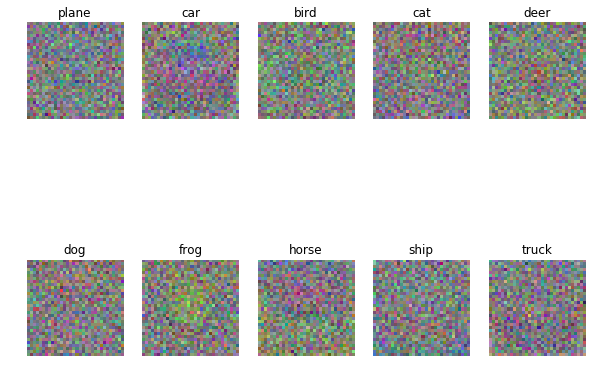

In [40]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])